# Table of contents
1. [Load, study and preprocess the data](#paragraph1)
    1. [Checking for duplicates](#subparagraph1)
    2. [Checking for  missing values](#subparagraph2)
    3. [Finalizing the dataset](#subparagraph3)
    4. [Conclusion](#subparagraph4)
2. [Addition of calculated variables](#paragraph2)
    1. [Addition of duration variable](#subparagraph5)
    2. [Filtering the data](#subparagraph6)
    3. [Calculate daily, weekly and monthly users](#subparagraph7)
3. [Exploratory data analysis](#paragraph3)
    1. [Barplot of rides per day for each group](#subparagraph8)
    2. [Barplot of duration per day for each group](#subparagraph9)
    3. [Histogram and QQ plots of the number of rides and the duration for each group](#subparagraph10)       
    4. [Testing statistical hypotheses](#subparagraph11)
4. [Overall conclusion](#paragraph4)

# Load, study and preprocess the data  <a name="paragraph1"></a>

We import all our tools and the data, we check the data types and select the necessary columns to continue our analysis.

In [1]:
#!pip install missingno --quiet
#!pip install seaborn --quiet

import seaborn as sns

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import mannwhitneyu as mw
from scipy import stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# This function takes a day integer and converts it to the name of the day.
# (Here weeks starts at Sunday ('Sun'= 0))
def weekday_to_dayname(day):
    if day == 1:
        return "Mon"
    if day == 2:
        return "Tue"
    if day == 3:
        return "Wed"
    if day == 4:
        return "Thu"
    if day == 5:
        return "Fri"
    if day == 6:
        return "Sat"
    if day == 0:
        return "Sun"

In [3]:
# Import our dataset (it's an Excel file, which has the combined data from the above url).
df = pd.read_csv('~path/bike_share.csv')
df.info()

data = df.drop(['_file', 'start_station_id', 'end_station_id'], axis=1)
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3541683 entries, 0 to 3541682
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
 13  _file               int64  
dtypes: float64(4), int64(1), object(9)
memory usage: 378.3+ MB


,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual
0,EACB19130B0CDA4A,docked_bike,2020-01-21 20:06:59,2020-01-21 20:14:30,Western Ave & Leland Ave,Clark St & Leland Ave,41.9665,-87.6884,41.9671,-87.6674,member
1,8FED874C809DC021,docked_bike,2020-01-30 14:22:39,2020-01-30 14:26:22,Clark St & Montrose Ave,Southport Ave & Irving Park Rd,41.9616,-87.6660,41.9542,-87.6644,member
2,789F3C21E472CA96,docked_bike,2020-01-09 19:29:26,2020-01-09 19:32:17,Broadway & Belmont Ave,Wilton Ave & Belmont Ave,41.9401,-87.6455,41.9402,-87.6530,member
3,C9A388DAC6ABF313,docked_bike,2020-01-06 16:17:07,2020-01-06 16:25:56,Clark St & Randolph St,Fairbanks Ct & Grand Ave,41.8846,-87.6319,41.8918,-87.6206,member
4,943BC3CBECCFD662,docked_bike,2020-01-30 08:37:16,2020-01-30 08:42:48,Clinton St & Lake St,Wells St & Hubbard St,41.8856,-87.6418,41.8899,-87.6343,member


## Checking for duplicates <a name="subparagraph1"></a>

We have noticed that `ride_id` has some multiple records, e.g. ride coded as 2EDD39499F0C1ACB has two entries. We have to remove these duplicates in order for our analysis to be correct.

In [4]:
data.query('ride_id == "2EDD39499F0C1ACB"')

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual
3360509,2EDD39499F0C1ACB,docked_bike,2020-11-25 16:27:05,2020-11-25 16:48:49,State St & 35th St,Blue Island Ave & 18th St,41.831036,-87.626797,41.857556,-87.661535,member
3440201,2EDD39499F0C1ACB,docked_bike,2020-12-15 12:15:40,2020-11-25 16:48:49,State St & 35th St,Blue Island Ave & 18th St,41.831036,-87.626797,41.857556,-87.661535,member


In [5]:
print('Number of duplicates for the ride_id column:', data.duplicated(subset=['ride_id']).sum())

Number of duplicates for the ride_id column: 209


In [6]:
data = data.drop_duplicates(subset=['ride_id'])

## Checking for  missing values <a name="subparagraph2"></a>

We will check the entire data for missing values.

In [7]:
print('The number of missing values in our dataset is:',data.isnull().sum())

The number of missing values in our dataset is: ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name     94656
end_station_name      110880
start_lat                  0
start_lng                  0
end_lat                 4254
end_lng                 4254
member_casual              0
dtype: int64


In [8]:
print('In addition, as the missing values are {:.2%} of all our data, we can remove them.'.format(data['end_station_name'].isna().sum()/len(data)))

In addition, as the missing values are 3.13% of all our data, we can remove them.


<AxesSubplot:>

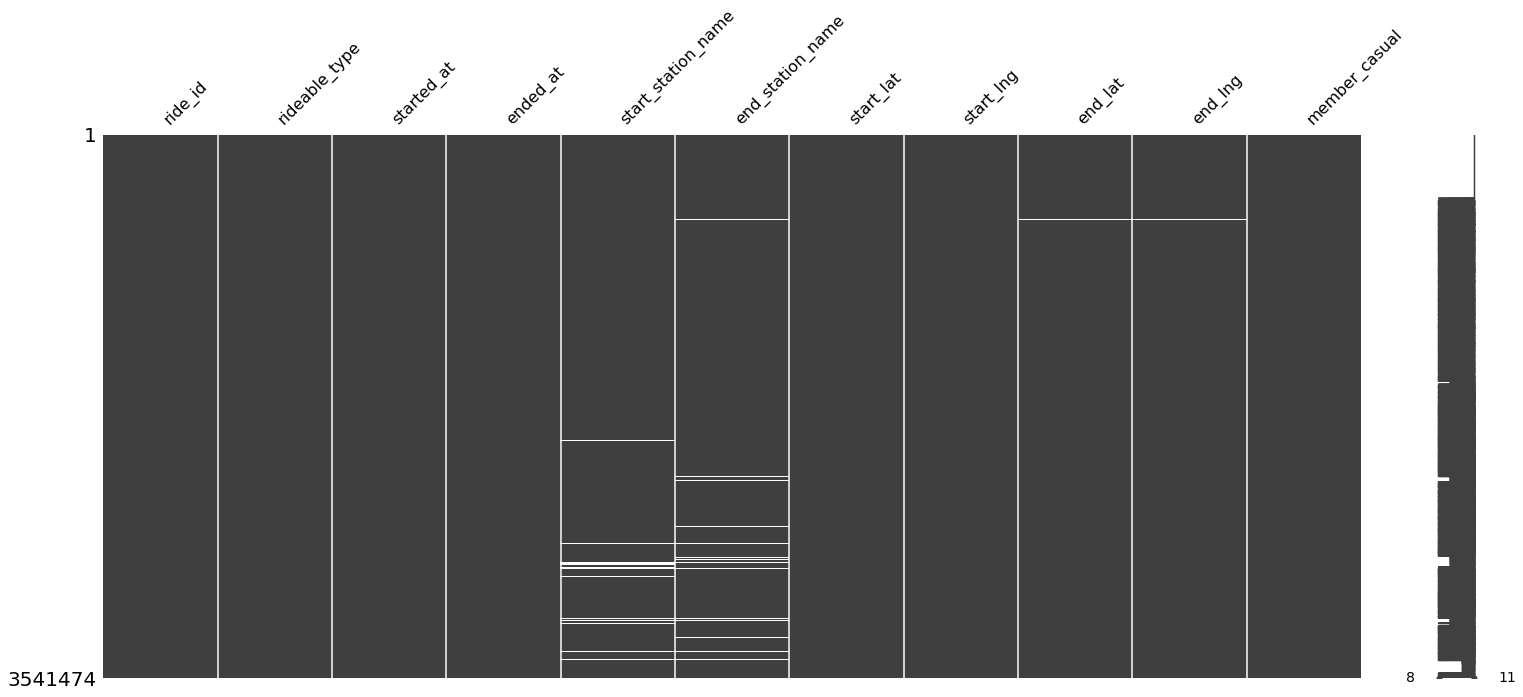

In [9]:
msno.matrix(data)

## Finalizing the dataset <a name="subparagraph3"></a>

In [10]:
data = data.dropna() # Drop missing values
# Changing dates to appropriate format, in order to calculate duration of each ride.
data['started_at'] = pd.to_datetime(
    data['started_at'], format='%Y-%m-%d %H:%M:%S')
data['ended_at'] = pd.to_datetime(data['ended_at'], format='%Y-%m-%d %H:%M:%S')
data['date'] = pd.DatetimeIndex(data['started_at']).date

## Conclusion <a name="subparagraph4"></a>

1. We have found duplicates in the `ride_id` variable and we removed them. We also found missing values in our categorical variables `start_station_name` and `end_station_name` which are missing not at random (MNAR). The values are missing for a reason and the likelihood that a value is missing can not be explained with reference to other values in the data. Possible causes of the missing values are:
 - GPS has a malfunction and did not register start and/or end stations.
 - Data entry errors.
 
2. In order to reduce memory usage, we dropped unnecessary columns and changed the type of `started_at` and `ended_at` variable to datetime64[ns] in order to make further calculations.
3. We removed missing values from the columns `started_at` and `ended_at`. Now our dataset has 3,390,045 observations.

# Addition of calculated variables and filtering <a name="paragraph2"></a>

## Addition of `duration` variable <a name="subparagraph5"></a>

We will calculate the variable `duration`, which is the duration in minutes for every ride. We will exclude ineligible rides, which are rides with negative duration, as they propably are malfunctions of the recording system.

In [11]:
# Calculate variable
data['duration'] = ((data['ended_at'] - data['started_at']) / np.timedelta64(1,'m')).astype('float32')
data['duration'].describe()

count    3.390045e+06
mean     2.706216e+01
std      3.691994e+02
min     -2.904997e+04
25%      7.716667e+00
50%      1.416667e+01
75%      2.605000e+01
max      1.564504e+05
Name: duration, dtype: float64

In [12]:
st.mode(data['duration'])

ModeResult(mode=array([0.03333334], dtype=float32), count=array([4046]))

The average length of each ride is 27.062 minutes with a median of 14.16 minutes. We also calculate the mode (0.033), which is the the most commonly occurring value. The standard deviation is 369.2 minutes, with minimum (-29049.97) and maximum (156450.4, meaning 24 days). Our dataset is clearly problematic and we need to filter our data in order to be able to derive valuable information from it.

## Filtering the data <a name="subparagraph6"></a>

We will filter out negative and excessive positive values. We explain our reasoning below. We save our filtered data to use it in Tableau, in order to make visualizations.

In [13]:
# Query our dataset with rides with duration more than 1 and less than 240 minutes.
eligible_sessions = data.query('duration > 1 and duration < 240')

# This creates a csv file with the filtered data to import to Tableau.
#eligible_sessions.to_csv('~path/eligible_sessions.csv')

eligible_sessions['duration'].describe()

count    3.319055e+06
mean     2.214390e+01
std      2.521885e+01
min      1.016667e+00
25%      7.983333e+00
50%      1.436667e+01
75%      2.613333e+01
max      2.399833e+02
Name: duration, dtype: float64

The average length of each ride is 22.21 minutes with a median of 14.36 minutes. We also calculate the mode (=5.63), which is the the most commonly occurring value. The standard deviation is 25.21 minutes, with a minimum ride of 1.017 and a maximum of 239.983.


In [14]:
st.mode(eligible_sessions['duration'])

ModeResult(mode=array([5.633333], dtype=float32), count=array([2834]))

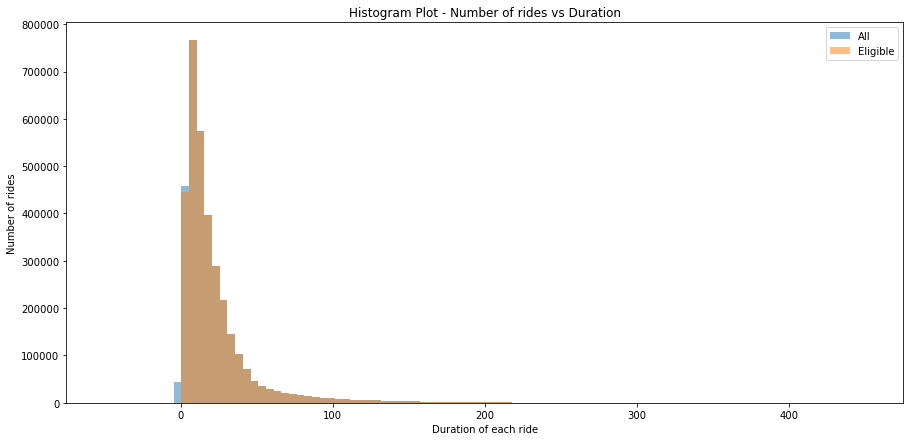

In [15]:
plt.figure(figsize=(15, 7))
bins = np.linspace(-50, 450, 100)
plt.hist(data['duration'], bins, alpha=0.5, label='All')
plt.hist(eligible_sessions['duration'], bins, alpha=0.5, label='Eligible')
plt.xlabel('Duration of each ride')
plt.ylabel('Number of rides')
plt.title('Histogram Plot - Number of rides vs Duration')
plt.legend(loc='upper right')
plt.show()

The above histogram depicts how many rides fall in each category of duration. We have removed all rides that are less than a minute, as we focus on longer rides, any negative sessions and any ride more than 240 minutes<sup>1</sup>, in order to have a clear view of the each ride's duration. We see that most rides have a duration that ranges from 0 to 240 minutes (previous max value 156450 minutes). We have a right-skewed distribution as the mean is greater than the median (as confirmed from the describe() method). The right shape indicates that there are some outliers that are greater than the mode. As we removed outliers our histogram right tail is cut off.

<sup>1</sup> Here we build upon our thinking about removing rides > 240 minutes. According to [U.S. Census Bureau, 2012-2016 American Community Survey 5-year estimates](https://www.census.gov/library/visualizations/interactive/travel-time.html) the U.S. average commute is 26.1 minutes, with some metros averaging as high as 38.6 and some as low as 15.4.

## Calculate daily, weekly and monthly users <a name="subparagraph7"></a>

To know how many people use our services we calculate daily, weekly and monthly usage. We add the `month`, `week` and `day` variables.

In [16]:
# Create columns with the month, week and day each ride hat started
eligible_sessions['month'] = eligible_sessions['started_at'].dt.month.astype('int32')
eligible_sessions['week']  = eligible_sessions['started_at'].dt.week.astype('int32')
eligible_sessions['day']   = eligible_sessions['started_at'].dt.dayofweek.apply(weekday_to_dayname)

# Daily, weekly, monthly and by day users of our service
dr  = eligible_sessions.groupby('date').agg({'ride_id': 'nunique'})  # Daily Rides
wr  = eligible_sessions.groupby('week').agg({'ride_id': 'nunique'})  # Weekly Rides
mr  = eligible_sessions.groupby('month').agg({'ride_id': 'nunique'}) # Montly Rides
bdr = eligible_sessions.groupby('day').agg({'ride_id': 'nunique'})   # By day Rides

print('On average, our services are being used each day {:.1f} times, each week {:.1f} times and each month {:.1f} times.'.format(dr.mean()[0],wr.mean()[0], mr.mean()[0]))

On average, our services are being used each day 9118.3 times, each week 62623.7 times and each month 276587.9 times.


In [17]:
# This code section is for illustration purposes only 

# Create a weekly period (starting with Sunday) from minumum to maximum date   
date_range_weekly = pd.period_range(start = eligible_sessions['started_at'].min(), end =  
                             eligible_sessions['ended_at'].max(), freq = 'W-SUN')

# 
date_range_weekly = date_range_weekly.map(str).str.split('/').str[0]
date_range_weekly = pd.Series(date_range_weekly)

# Assign the above periods as Index and delete the last row (which is in 2021)
wr = wr.assign(Weeks = date_range_weekly).set_index(['Weeks']).iloc[:-1,:]

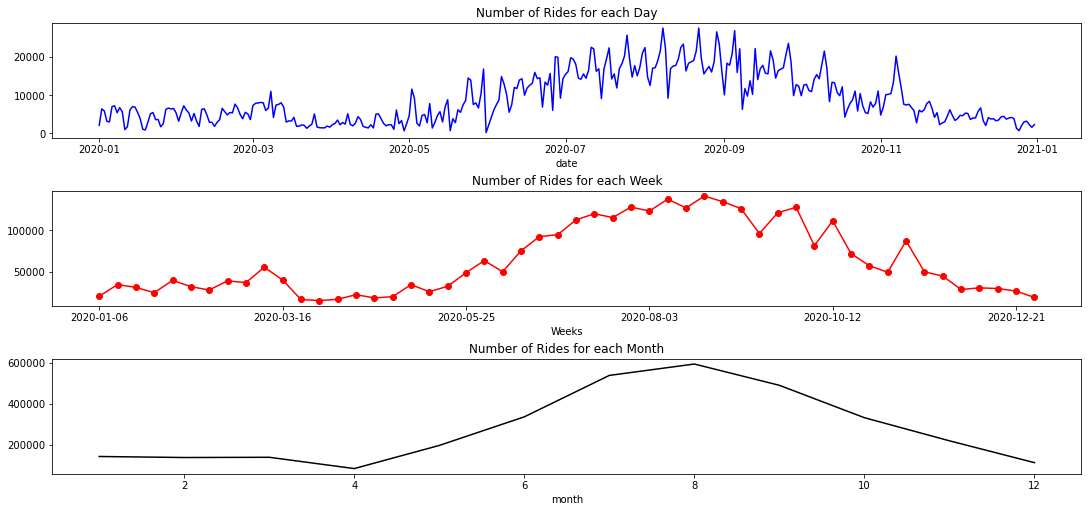

In [18]:
plt.figure(1, figsize=(15, 7), constrained_layout=True)

plt.subplot(311)
dr['ride_id'].plot(color='blue', linestyle='-', label='daily')
plt.title('Number of Rides for each Day')

plt.subplot(312)
wr['ride_id'].plot(color='red', marker='o', label='weekly')
plt.title('Number of Rides for each Week')

plt.subplot(313)
mr['ride_id'].plot(color='black', label='monthly')
plt.title('Number of Rides for each Month')
    
plt.show()

The above graphs gives us a first picture on how our customers use our services. We can clearly see that most rides happen from May to October (as there is better weather that time). With August being the top month and December the last. We would like to see how rides are distributed across the whole week. Below we can see that Friday has the most rides, followed by Saturday and Thursday.

# Exploratory data analysis <a name="paragraph3"></a>
We will continue exploring our dataset in order to find interesting patterns.

## Barplot of rides per day for each group <a name="subparagraph8"></a>


<Figure size 1080x504 with 0 Axes>

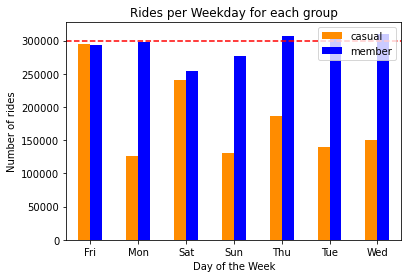

In [19]:
plt.figure(figsize=(15, 7))
eligible_sessions.groupby(['day', 'member_casual']).size().unstack().plot.bar(color=tuple(["DarkOrange", "Blue"]))
plt.xlabel('Day of the Week')
plt.ylabel('Number of rides')
plt.title('Rides per Weekday for each group')
plt.legend(loc='upper right')
plt.xticks(rotation=360)
plt.axhline(y=300000, color='red', linestyle='--')
plt.show()

An interesting graph is the rides per day for each group, where: 
- Members have a consistent number of rides around the working days (~300,000). There is a drop on weekends (especially on Saturday).
- Casual riders have a different pattern. They ride less on Sun-Mon-Tue-Wed and more on Thu-Fri-Sat.
- The number of rides are almost equal between the groups on Friday and on Saturday, but they merge from different levels. Rides from casuals are increasing (from the working days) while rides from members are decreasing.
- Friday, where the highest number of rides occur, has an almost equal share of rides between members and casuals.

We will divide our dataset to two groups, casuals and members and describe their statistical characteristics.

In [20]:
df_members = eligible_sessions.query(
    'member_casual=="member"')
df_casuals = eligible_sessions.query(
    'member_casual== "casual"')

In [21]:
df_members['duration'].describe()

count    2.050409e+06
mean     1.490765e+01
std      1.276394e+01
min      1.016667e+00
25%      6.566667e+00
50%      1.130000e+01
75%      1.960000e+01
max      2.398333e+02
Name: duration, dtype: float64

For the members group, the average length of each ride is 14.91 minutes with a median of 11.30 minutes. The standard deviation is 12.76 minutes, with a minimum ride of 1.017 and a maximum of 239.983.

In [22]:
df_casuals['duration'].describe()

count    1.268646e+06
mean     3.381184e+01
std      3.440711e+01
min      1.016667e+00
25%      1.226667e+01
50%      2.200000e+01
75%      4.086666e+01
max      2.399833e+02
Name: duration, dtype: float64

For the casuals group, the average length of each ride is 33.81 minutes with a median of 22 minutes. The standard deviation is 34.40 minutes, with a minimum ride of 1.017 and a maximum of 239.983.

## Barplot of duration per day for each group <a name="subparagraph9"></a>


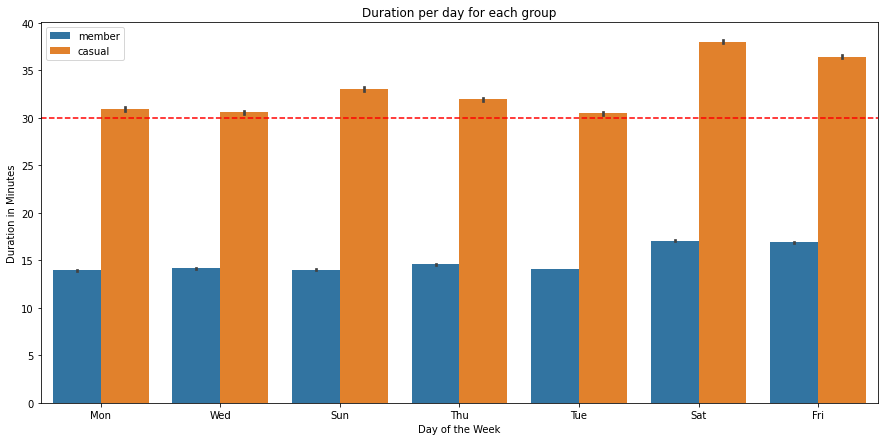

In [23]:
plt.figure(figsize=(15, 7))
sns.barplot(data=eligible_sessions, x='day', y='duration', hue='member_casual')
plt.xlabel('Day of the Week')
plt.ylabel('Duration in Minutes')
plt.title('Duration per day for each group')
plt.legend(loc='upper left')
plt.axhline(y=30, color='red', linestyle='--')
plt.show()

The above barplot depicts the average ride duration for each day between the two groups. We see that for members, weekday rides have a duration less than 15 minutes and on weekends above 15 minutes. Casual riders have a weekday duration above 30 minutes and a weekend duration above 35 minutes.

## Histogram and QQ plots of the number of rides and the duration for each group <a name="subparagraph10"></a>


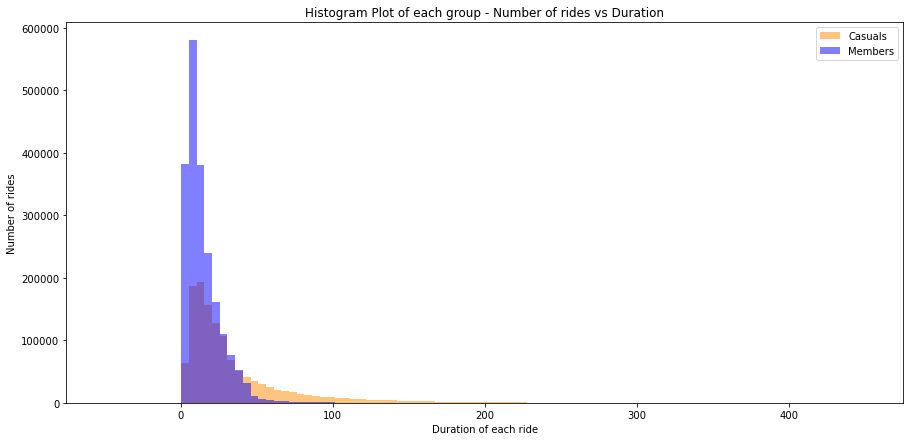

In [24]:
plt.figure(figsize=(15, 7))
bins = np.linspace(-50, 450, 100)
plt.hist(df_casuals['duration'], bins, alpha=0.5, label='Casuals', color="DarkOrange")
plt.hist(df_members['duration'], bins, alpha=0.5, label='Members', color="Blue")
plt.xlabel('Duration of each ride')
plt.ylabel('Number of rides')
plt.title('Histogram Plot of each group - Number of rides vs Duration')
plt.legend(loc='upper right')
plt.show()

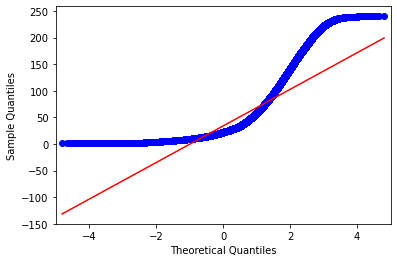

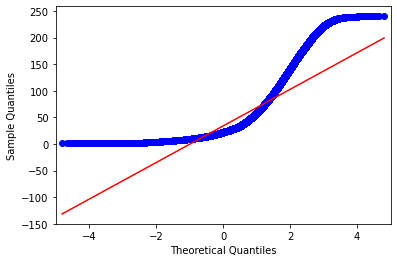

In [25]:
qqplot(df_casuals['duration'], line='s')

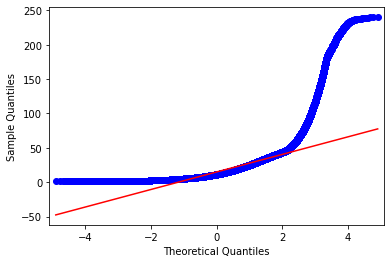

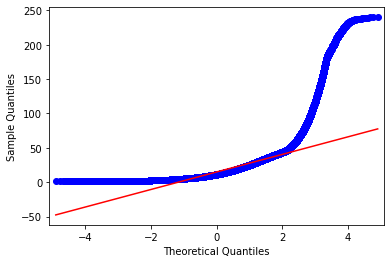

In [26]:
qqplot(df_members['duration'], line='s')

The above histogram depicts how many rides fall in each category of duration between groups. We see that for members, rides have a duration that ranges from 0 to 100 minutes, whilst for casual from 0 to 200. Most members' rides are less than 60 minutes while casuals' distribution is more right-skewed meaning that there are some outliers. Additionally, the QQ plots show that the scatter plot of points is not on the diagonal line, thus not fitting the expected diagonal pattern for a sample from a Gaussian distribution, for both samples. There are major deviations, both at the top and at the bottom of the plot that indicates the use of non parametric statistical tests.

## Testing statistical hypotheses  <a name="subparagraph11"></a>

For statistical testing, we will use the mean (as it is the most commonly used measure of central tendency for quantitative data). We will first test whether or not our samples come from populations with equal variances. As there are significant deviations from normality we will use the Levene test with the median as center (although in our case we have filtered the data, our samples still have skewed (non-normal) distributions).

In [27]:
st.levene(df_casuals['duration'], df_members['duration'], center='median')

LeveneResult(statistic=339852.7965403317, pvalue=0.0)

With a Levene statistic of 339852 and a pvalue of 0.0, we cannot accept the H<sub>0</sub> hypothesis of equal variances. From the histograms, QQ plots and the Levene test, there is no use to conduct a Shapiro-Wilk, thus we will use the Mann-Whitney U test for comparing independent data samples: the nonparametric version of the Student t-test. We implement a two sided test and we use the significance level of 5%. The hypotheses are: 

> H<sub>0</sub>: Sample distributions are equal (The two populations are equal).

> H<sub>1</sub>: Sample distributions are not equal (The two populations are not equal).

In [28]:
# compare samples
stat, p = mw(df_casuals['duration'], df_members['duration'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample distributions are NOT different (fail to reject H0).')
else:
    print('Sample distributions are different (reject H0).')

Statistics=1872046731868.500, p=0.000
Sample distributions are different (reject H0).


The p-value strongly suggests that the sample distributions are different, indicating that the duration differs from a casual to a member customer.

# Overall conclusion <a name="paragraph4"></a>

*Final Findings*

- Members have a consistent number of rides around the working days (~300,000). There is a drop on weekends (especially on Saturday).
- Casuals ride less on Sun-Mon-Tue-Wed and more on Thu-Fri-Sat.
- The number of rides are almost equal between the groups on Friday and on Saturday.
- Friday, where the highest number of rides occur, has an equal share of rides between members and casuals
- On average, our services are being used each day 9118.3 times, each week 62623.7 times and each month 276587.9 times.
- Trips for casuals are longer on average than those for members, in some cases more than, on average, twice as long. This indicates that members use the service for shorter -commuting to work- rides, whilst casuals seem to use it for leisure rides. 
- Durations between groups are indeed different.

*Recommendations*

1. Position bike stations to work and residential areas, as customers who use their bikes for commuting to work are more likely to subscribe to an annual membership.
2. Change payment schemes, e.g., few rides on busy days (Fri-Sat-Sun) should cost way more than rides for the same time periods for annual subscription. In essence, 'penalize' irregular use in order for the annual subscription to worth more for the average user.  
3. Targeted offers to casual users who:
    - Use the same stations as members.
    - Reach a certain number of rides or/and duration.